In [17]:
#############################################################################
# zlib License
#
# (C) 2023 Zach FLowers, Jongho Lee, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

## Imports

In [18]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import datetime
from tqdm import tqdm
from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import importlib
importlib.reload(run_script)
import pickle
import pandas
from pathlib import Path
import subprocess

import sqlite3

## Specify board name

In [19]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
chip_name = "ET2_W36_IP5_18"
# chip_figname = f"LowBiasCurrent_HVon100V_C26Removed_Ext10KOhm_{chip_name}"
# chip_figtitle= "LowBiasCurrent HVon100V C26Removed Ext10KOhm "+chip_name
# CblHVandGNDExtDouble
# chip_figname = f"LowBiasCurrent_HVon100V_L7Removed_50kFIFO_L1A_{chip_name}"
# chip_figtitle= "LowBiasCurrent HVon100V L7Removed 50kFIFO L1A "+chip_name

chip_figname = f"LowBiasCurrent_HVoff_SelfTrigger_{chip_name}"
chip_figtitle= "LowBiasCurrent HVoff SelfTrigger"+chip_name

fig_outdir = Path('../ETROC-figures')
fig_outdir = fig_outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

## Set defaults

In [20]:
# 'If set, the full log will be saved to a file (i.e. the log level is ignored)'
log_file = False
# 'Set the logging level. Default: WARNING',
#  ["CRITICAL","ERROR","WARNING","INFO","DEBUG","TRACE","DETAILED_TRACE","NOTSET"]
log_level_text = "WARNING"
# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "/dev/ttyACM0"
# I2C addresses for the pixel block and WS
chip_address = 0x60
ws_address = None

In [21]:
if log_file:
    logging.basicConfig(filename='logging.log', filemode='w', encoding='utf-8', level=logging.NOTSET)
    log_level = 0
else:
    log_level = 0
    if log_level_text == "CRITICAL":
        log_level=50
    elif log_level_text == "ERROR":
        log_level=40
    elif log_level_text == "WARNING":
        log_level=30
    elif log_level_text == "INFO":
        log_level=20
    elif log_level_text == "DEBUG":
        log_level=10
    elif log_level_text == "TRACE":
        log_level=8
    elif log_level_text == "DETAILED_TRACE":
        log_level=5
    elif log_level_text == "NOTSET":
        log_level=0
    logging.basicConfig(format='%(asctime)s - %(levelname)s:%(name)s:%(message)s')

i2c_gui.__no_connect__ = False  # Set to fake connecting to an ETROC2 device
i2c_gui.__no_connect_type__ = "echo"  # for actually testing readback
#i2c_gui.__no_connect_type__ = "check"  # default behaviour

## Start logger and connect

In [22]:
logger = logging.getLogger("Script_Logger")

Script_Helper = i2c_gui.ScriptHelper(logger)

## USB ISS connection
conn = i2c_gui.Connection_Controller(Script_Helper)
conn.connection_type = "USB-ISS"
conn.handle: USB_ISS_Helper
conn.handle.port = port
conn.handle.clk = 100

## For FPGA connection (not yet fully implemented)
#conn.connection_type = "FPGA-Eth"
#conn.handle: FPGA_ETH_Helper
#conn.handle.hostname = "192.168.2.3"
#conn.handle.port = "1024"

conn.connect()

In [23]:
chip = i2c_gui.chips.ETROC2_Chip(parent=Script_Helper, i2c_controller=conn)
chip.config_i2c_address(chip_address)  # Not needed if you do not access ETROC registers (i.e. only access WS registers)
# chip.config_waveform_sampler_i2c_address(ws_address)  # Not needed if you do not access WS registers

logger.setLevel(log_level)

## Useful Functions

In [24]:
def pixel_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Pixel Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_indexed_var("ETROC2", "Pixel Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)

def pixel_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_indexed_var("ETROC2", f"Pixel {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Pixel {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

def peripheral_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Peripheral Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)

def peripheral_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_display_var("ETROC2", f"Peripheral {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Peripheral {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

# Pixel ID Check

In [25]:
Failure_map = np.zeros((16,16))
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for row in range(16):
    for col in range(16):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        fetched_row = pixel_decoded_register_read("PixelID-Row", "Status", need_int=True)
        fetched_col = pixel_decoded_register_read("PixelID-Col", "Status", need_int=True)
        if(row!=fetched_row or col!=fetched_col):
            print("Fail!", row, col, fetched_row, fetched_col)
            Failure_map[15-row,15-col] = 1

In [26]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt

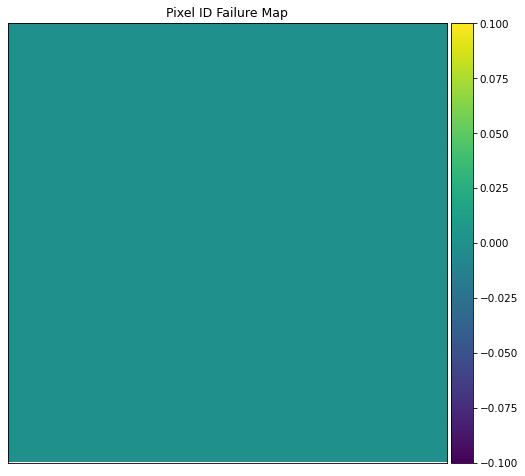

In [27]:
fig = plt.figure(dpi=75, figsize=(8,8))
gs = fig.add_gridspec(1,1)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("Pixel ID Failure Map")
img0 = ax0.imshow(Failure_map, interpolation='none')
ax0.set_aspect("equal")
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")
plt.show()

## Set Peripheral Registers

In [28]:
peripheral_decoded_register_write("EFuse_Prog", format(0x00017f0f, '032b'))
peripheral_decoded_register_write("singlePort", '1')
peripheral_decoded_register_write("serRateLeft", '00')
peripheral_decoded_register_write("serRateRight", '00')
peripheral_decoded_register_write("onChipL1AConf", '00')
peripheral_decoded_register_write("PLL_ENABLEPLL", '1')
peripheral_decoded_register_write("chargeInjectionDelay", format(0x0a, '05b'))
peripheral_decoded_register_write("triggerGranularity", format(0x01, '03b')) # only for trigger bit

In [ ]:
decodedRegisterNames = list(register_decoding["ETROC2"]["Register Blocks"]["Peripheral Config"].keys())
for decodedRegisterName in decodedRegisterNames:
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)
    data_str = handle.get()
    data_int = int(data_str, base=16)
    data_bin = format(data_int, f'0{register_decoding["ETROC2"]["Register Blocks"]["Peripheral Config"][decodedRegisterName]["bits"]}b')
    data_hex = hex(int(data_bin, base=2))
    print(f"{decodedRegisterName:25}", f"{data_str:10}", f"{data_hex:10}", f"{data_int:10}", f"{data_bin:32}", register_decoding["ETROC2"]["Register Blocks"]["Peripheral Config"][decodedRegisterName]["bits"])

In [ ]:
decodedRegisterNames = list(register_decoding["ETROC2"]["Register Blocks"]["Peripheral Status"].keys())
for decodedRegisterName in decodedRegisterNames:
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Status", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Peripheral Status", decodedRegisterName)
    data_str = handle.get()
    data_int = int(data_str, base=16)
    data_bin = format(data_int, f'0{register_decoding["ETROC2"]["Register Blocks"]["Peripheral Status"][decodedRegisterName]["bits"]}b')
    data_hex = hex(int(data_bin, base=2))
    print(f"{decodedRegisterName:25}", f"{data_str:10}", f"{data_hex:10}", f"{data_int:10}", f"{data_bin:32}", register_decoding["ETROC2"]["Register Blocks"]["Peripheral Status"][decodedRegisterName]["bits"])
    
    

# Force Re-align of the FC

Run this when you see inconsistent BCID in your data, even though you expect to see the same numbers for each cycle

In [ ]:
print(peripheral_decoded_register_read("asyAlignFastcommand", "Config"))

peripheral_decoded_register_write("asyAlignFastcommand", "1")
peripheral_decoded_register_write("asyAlignFastcommand", "0")

## Set Current Mode

In [ ]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")

# current_mode = 7  # Low current
current_mode = 0  # High current


for row in tqdm(range(16), desc=" row", position=0):
    for col in tqdm(range(16), desc=" col", position=1, leave=False):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)

        # Set current mode
        pixel_decoded_register_write("IBSel", format(current_mode, '03b'))

## Automatic threshold calibration

In [29]:
BL_map_THCal = np.zeros((16,16))
NW_map_THCal = np.zeros((16,16))

In [ ]:
# Read the IBsel and DAC for Pixel 3,3
# row_indexer_handle,_,_ = chip.get_indexer("row")
# column_indexer_handle,_,_ = chip.get_indexer("column")
# column_indexer_handle.set(3)
# row_indexer_handle.set(3)
# print(pixel_decoded_register_read("IBSel", "Config"))
# print(pixel_decoded_register_read("DAC", "Config"))

In [ ]:
# # This can bypass the THCal, and use user defined DAC threshold

# row_indexer_handle,_,_ = chip.get_indexer("row")
# column_indexer_handle,_,_ = chip.get_indexer("column")
# column_indexer_handle.set(0)
# row_indexer_handle.set(0)

# broadcast_handle,_,_ = chip.get_indexer("broadcast")
# broadcast_handle.set(True)
# pixel_decoded_register_write("Bypass_THCal", "1")

In [30]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
data = []
# Loop for threshold calibration
for row in tqdm(range(16), desc=" row", position=0):
    for col in tqdm(range(16), desc=" col", position=1, leave=False):
# for index,row,col in zip(tqdm(range(16)), row_list, col_list):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # Maybe required to make this work
        # pixel_decoded_register_write("enable_TDC", "0")
        # pixel_decoded_register_write("testMode_TDC", "0")
        # Enable THCal clock and buffer, disable bypass
        pixel_decoded_register_write("CLKEn_THCal", "1")
        pixel_decoded_register_write("BufEn_THCal", "1")
        pixel_decoded_register_write("Bypass_THCal", "0")
        pixel_decoded_register_write("TH_offset", format(0x04, '06b'))
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Check the calibration done correctly
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
        NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
        data += [{
            'col': col,
            'row': row,
            'baseline': BL_map_THCal[row, col],
            'noise_width': NW_map_THCal[row, col],
            'timestamp': datetime.datetime.now(),
            'chip_name': chip_name,
        }]
        # Disable clock and buffer before charge injection 
        pixel_decoded_register_write("CLKEn_THCal", "0") 
        pixel_decoded_register_write("BufEn_THCal", "0")
        
        #pixel_decoded_register_write("DAC", format(0, '010b'))
        #pixel_decoded_register_write("Bypass_THCal", "1")
        # Set Charge Inj Q to 15 fC
        pixel_decoded_register_write("QSel", format(0x1e, '05b'))
        time.sleep(0.1)

BL_df = pandas.DataFrame(data = data)

 row: 100%|██████████| 16/16 [02:14<00:00,  8.41s/it]


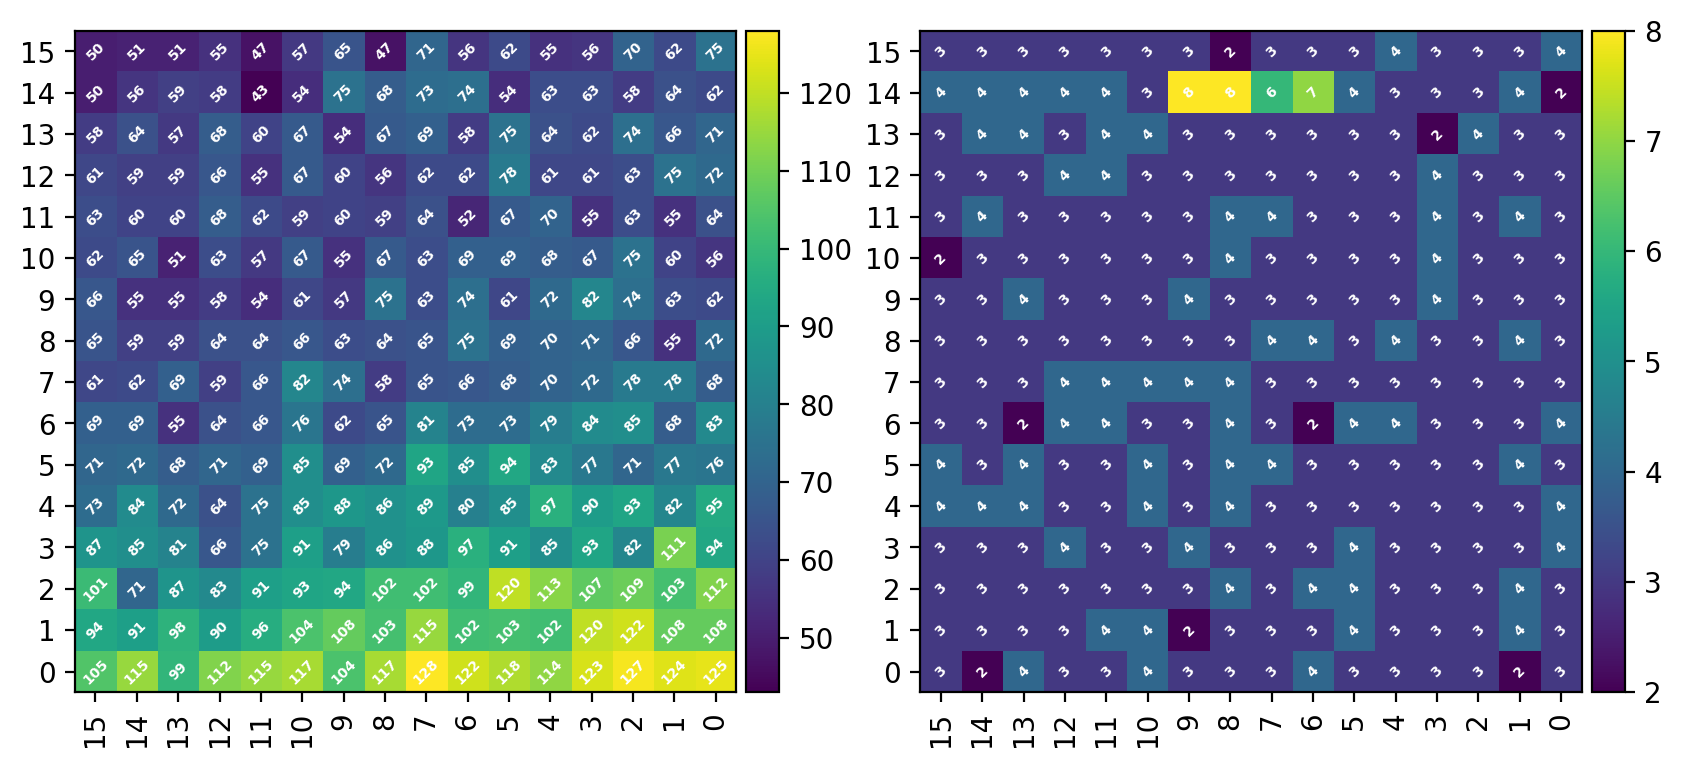

In [31]:
fig = plt.figure(dpi=200, figsize=(10,10))
gs = fig.add_gridspec(1,2)

ax0 = fig.add_subplot(gs[0,0])
# ax0.set_title("BL (DAC LSB), "+chip_figtitle, size=8)
img0 = ax0.imshow(BL_map_THCal, interpolation='none')
ax0.set_aspect("equal")
ax0.invert_xaxis()
ax0.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

ax1 = fig.add_subplot(gs[0,1])
# ax1.set_title("NW (DAC LSB), "+chip_figtitle, size=8)
img1 = ax1.imshow(NW_map_THCal, interpolation='none')
ax1.set_aspect("equal")
ax1.invert_xaxis()
ax1.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img1, cax=cax, orientation="vertical")

for x in range(16):
    for y in range(16):
        # if(BL_map_THCal.T[x,y]==0): continue
        ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
        ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
plt.savefig(fig_path+"/BL_NW_"+chip_figname+"_"+datetime.date.today().isoformat()+".png")
# plt.show()

### Store BL, NW dataframe for later use

In [ ]:
outdir = Path('../ETROC-Data')
outdir = outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
outdir.mkdir(exist_ok=True)
outfile = outdir / (chip_name+"_BaselineAt_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv")
BL_df.to_csv(outfile, index=False)

### Store BL, NW dataframe in database

In [ ]:
new_columns = {
    'note': f'{chip_figname}',
}

for col in new_columns:
    BL_df[col] = new_columns[col]

outdir = Path('../ETROC-Data')
outfile = outdir / 'BaselineHistory.sqlite'

init_cmd = [
    'cd ' + str(outdir.resolve()),
    'git stash -u',
    'git pull',
]
end_cmd = [
    'cd ' + str(outdir.resolve()),
    'git add BaselineHistory.sqlite',
    'git commit -m "Added new history entry"',
    'git push',
    'git stash pop',
    'git stash clear',
]
init_cmd = [x + '\n' for x in init_cmd]
end_cmd  = [x + '\n' for x in end_cmd]

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

for cmd in init_cmd:
    p.stdin.write(cmd + "\n")
p.stdin.close()
p.wait()

print(p.stdout.read())

with sqlite3.connect(outfile) as sqlconn:
    BL_df.to_sql('baselines', sqlconn, if_exists='append', index=False)

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

for cmd in end_cmd:
    p.stdin.write(cmd + "\n")
p.stdin.close()
p.wait()

p.stdin.close()

print(p.stdout.read())


### Disable all pixels

In [33]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")
column_indexer_handle.set(0)
row_indexer_handle.set(0)

broadcast_handle,_,_ = chip.get_indexer("broadcast")
broadcast_handle.set(True)
pixel_decoded_register_write("disDataReadout", "1")
broadcast_handle.set(True)
pixel_decoded_register_write("QInjEn", "0")
broadcast_handle.set(True)
pixel_decoded_register_write("disTrigPath", "1")

### Define pixels of interest

In [34]:
# Diagnoal scan
# col_list = list(np.arange(16)[1:-1]) + list(np.arange(16)[1:-1])
# row_list = list(np.arange(16)[1:-1]) + list(np.arange(16)[::-1][1:-1])

# Box scan
# col_list = list(np.arange(16)[0:-1]) + list(np.full(15, 15)) + list(np.arange(16)[1:]) + list(np.full(15, 0))
# row_list = list(np.full(15, 0)) + list(np.arange(16)[0:-1]) + list(np.full(15, 15)) + list(np.arange(16)[1:])

# Cluster scan
# col_list = [3, 3, 3, 12, 12, 12]
# row_list = [3, 8, 13, 3, 8, 13]

#row_list = list(np.arange(4)[0:])
#col_list = np.zeros_like(row_list)
# row_list = [3,12,3,12]
# col_list = [3,3,12,12]
# row_list = [14, 14, 14, 14]
# col_list = [6, 7, 8, 9]
# row_list = [3,12]
# col_list = [3,3]
#row_list = [3]
#col_list = [3]
# print(col_list)
# print(row_list)

# Sensor board pixels of interest
# row_list = [14, 14, 14, 14, 15, 15, 15, 15]
# col_list = [6, 7, 8, 9, 6, 7, 8, 9]
# row_list = [15]
# col_list = [7]

# scan_list = list(zip(col_list, row_list))
# print(scan_list)

row_list = [15, 15, 15, 15]
col_list = [6, 7, 8, 9]
scan_list = list(zip(col_list, row_list))
print(scan_list)

[(6, 15), (7, 15), (8, 15), (9, 15)]


# For testing data taking

In [ ]:
# scan_name = "E2_testing_VRef_SCurve"
# total_number_pixels = len(row_list)
# time_per_pixel = 10
# dead_time_per_pixel = 5
# total_scan_time = total_number_pixels*(time_per_pixel + dead_time_per_pixel) + 10
# print(f"Scanning {total_number_pixels} pixels for a total of {total_scan_time} s")

# row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
# column_indexer_handle,_,_ = chip.get_indexer("column")

# parser = run_script.getOptionParser()
# (options, args) = parser.parse_args(args=f"--firmware --useIPC --hostname 192.168.2.3 -t {int(total_scan_time)} -o {scan_name} -v -w --compressed_translation".split())

# IPC_queue = multiprocessing.Queue()
# process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, 'main_process'))
# process.start()

# # Loop for enable/disable charge injection per pixel (single!!!)
# for index, row, col in zip(tqdm(range(len(row_list))), row_list, col_list):
#     column_indexer_handle.set(col)
#     row_indexer_handle.set(row)
#     # Modifying charge injected
#     # pixel_decoded_register_write("QSel", format(0x0e, '05b'))
#     # Enable charge injection
#     pixel_decoded_register_write("disDataReadout", "0")
#     pixel_decoded_register_write("QInjEn", "1")
#     time.sleep(1)
#     IPC_queue.put('start L1A 1MHz')
#     while not IPC_queue.empty():
#         pass
#     # DAQ time
#     time.sleep(time_per_pixel)
#     IPC_queue.put('stop L1A 1MHz')
#     while not IPC_queue.empty():
#         pass
#     time.sleep(1)
#     # Disable charge injection
#     pixel_decoded_register_write("QInjEn", "0")
#     pixel_decoded_register_write("disDataReadout", "1")
#     time.sleep(1)

# IPC_queue.put('allow threads to exit')
# process.join()

# ACC S-curve calibration

In [35]:
DAC_range = np.arange(0 ,100)
accdata = []

# DAC_range = np.arange(130, 250)
# row = 14
# col = 9
# DAC_range = np.arange(int(BL_map_THCal[row][col]-30), int(BL_map_THCal[row][col]+30))
ACC_map_Scurve = {row:{col:np.zeros_like(DAC_range) for col in range(16)} for row in range(16)}
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for col, row in tqdm(scan_list):
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    # Enable THCal clock and buffer and bypass
    pixel_decoded_register_write("CLKEn_THCal", "1")
    pixel_decoded_register_write("BufEn_THCal", "1")
    pixel_decoded_register_write("Bypass_THCal", "1")
    for index,DAC in enumerate(DAC_range):
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Set the DAC value to the value being scanned
        pixel_decoded_register_write("DAC", format(DAC, '010b'))
        # Start and Stop the calibration, maybe pause for 1ms (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        # time.sleep(.1)
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Fetch the status registers
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        ACC_map_Scurve[row][col][index] = pixel_decoded_register_read("ACC", "Status", need_int=True)
    
    accdata += [{
            'col': col,
            'row': row,
            'accscurve': ACC_map_Scurve[row][col],
            'xmin': np.amin(DAC_range),
            'xmax': np.amax(DAC_range)+1,
            'xstep': (np.amax(DAC_range)+1-np.amin(DAC_range))/DAC_range.size,
            'chip_name': chip_name,
            'timestamp': datetime.datetime.now(),
    }]
    
    # Disable THCal clock and buffer and bypass
    pixel_decoded_register_write("CLKEn_THCal", "0")
    pixel_decoded_register_write("BufEn_THCal", "0")
    # Set the DAC value to the vpreviously found BL + Offset (7)
    # pixel_decoded_register_write("DAC", format(int(BL_map_THCal[row,col]+7), '010b'))
    pixel_decoded_register_write("DAC", format(0, '010b'))
    time.sleep(0.1)

acc_df = pandas.DataFrame(data = accdata)
# Need to convert array to string, to save as SQL
acc_df['accscurve'] = acc_df['accscurve'].apply(lambda arr: ','.join(map(str, arr)))

100%|██████████| 4/4 [01:36<00:00, 24.20s/it]


In [ ]:
outdir = Path('../ETROC-Data')
outdir = outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
outdir.mkdir(exist_ok=True)
outfile = outdir / (chip_name+"_ACC_Scurve_At_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv")
acc_df.to_csv(outfile, index=False)

## Comparing Auto-THCal with ACC S-curve

In [ ]:
fig = plt.figure(dpi=200, figsize=(20,10))
u_cl = np.sort(np.unique(col_list))
u_rl = np.sort(np.unique(row_list))
gs = fig.add_gridspec(len(u_rl),len(u_cl))
for ri,row in enumerate(u_rl):
    for ci,col in enumerate(u_cl):
        ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
        ax0.plot(DAC_range, ACC_map_Scurve[row][col], 'b.-', label="S-curve")
        ax0.axvline(BL_map_THCal[row][col], color='r', label=f"THCal BL = {BL_map_THCal[row][col]}")
        ax0.axvline(BL_map_THCal[row][col]+0.5*NW_map_THCal[row][col], color='k', label=f"THCal NW = {NW_map_THCal[row][col]}")
        ax0.axvline(BL_map_THCal[row][col]-0.5*NW_map_THCal[row][col], color='k')
        ax0.axvline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='k', ls="--", label=f"THCal 2*NW = {2*NW_map_THCal[row][col]}")
        ax0.axvline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='k', ls="--")
        ax0.set_xlabel("DAC Value [LSB]")
        ax0.set_ylabel("ACC Value [decimal]")
        
        plt.legend()
        plt.title(chip_figtitle+f", Pixel {row},{col}", size=8)
plt.tight_layout()
plt.savefig(fig_path+"/THCal_SCurve_"+chip_figname+"_"+datetime.date.today().isoformat()+".png")

In [36]:
from scipy.optimize import curve_fit
from scipy.stats import crystalball, chisquare

# Define the composite Gaussian function
def composite_gaussian(x, a1, mean1, sigma1, a2, mean2, sigma2):
    gauss1 = a1 * np.exp(-(x - mean1) ** 2 / (2 * sigma1 ** 2))
    gauss2 = a2 * np.exp(-(x - mean2) ** 2 / (2 * sigma2 ** 2))
    return gauss1 + gauss2

def gaussian_func(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

def cball_func(x, a, mu, sigma, alpha, n):
    return a * crystalball.pdf(x, n, alpha, mu, sigma)

def return_closest_xvalue(x, value):
    return np.argmin(np.abs(x - value))

GMean_map_THCal = np.zeros((16,16))
GSigma_map_THCal = np.zeros((16,16))
x = DAC_range

fit_width = 15

for col, row in tqdm(scan_list):
    y = ACC_map_Scurve[row][col]
    dy_dx = -1*np.gradient(y, x)
    max_index = np.argmax(dy_dx)
    selection = (dy_dx>0) & (x>=x[max_index]-fit_width) & (x<=x[max_index]+fit_width)

    initial_guess = [1.0, x[max_index], 1.0]
    initial_guess_cball = [30000, -1*x[max_index], 5, 5, 1]

    popt, pcov = curve_fit(gaussian_func, x[selection], dy_dx[selection], p0=initial_guess)
    popt_cball, pcov_cball = curve_fit(cball_func, -1*x, dy_dx, p0=initial_guess_cball)
    a1_fit, mean1_fit, sigma1_fit = popt
    sigma1_fit = abs(sigma1_fit)
    GMean_map_THCal[row][col]  = mean1_fit
    GSigma_map_THCal[row][col] = sigma1_fit
    _, mean_cball_fit, sigma_cball_fit,_,_ = popt_cball

    y_fit1 = gaussian_func(x, *popt)
    y_cball_fit = cball_func(-1*x, *popt_cball)

    # Calculate R-squared value
    # ssr = np.sum((dy_dx - y_fit1) ** 2)
    # sst = np.sum((dy_dx - np.mean(y_fit1)) ** 2)
    # r_squared = 1 - (ssr / sst)
    # print('R squared:', r_squared)

    # Calculate the chi-square statistic
    # observed_values, _ = np.histogram(dy_dx, bins=len(x))
    # expected_values = gaussian_func(x, a1_fit, mean1_fit, sigma1_fit)
    # chi2, p_value = chisquare(observed_values, expected_values)
    # print('Chi-Square Statistic:', chi2, 'P-value:', p_value)

    # Plot the differentials
    # fig = plt.figure(dpi=100, figsize=(6,6))
    # plt.plot(x, dy_dx, 'b.', label='Gradient')
    # plt.plot(x, y_fit1, color='r', linestyle='-', label='Peak Gaussian Fit')
    # plt.plot(x, y_cball_fit, color='g', linestyle='--', label='Crystal Ball')
    # plt.axhline(0, ls='--', color='k')
    # plt.axvline(x[max_index]-fit_width, ls='--', color='k')
    # plt.axvline(x[max_index]+fit_width, ls='--', color='k')
    # plt.xlabel("DAC Value [LSB]")
    # plt.ylabel("PDF from ACC Value")
    # plt.legend()
    # plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]/home/daq/ETROC2/i2c_gui/venv/lib64/python3.9/site-packages/scipy/stats/_continuous_distns.py:9623: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/daq/ETROC2/i2c_gui/venv/lib64/python3.9/site-packages/scipy/stats/_continuous_distns.py:9623: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
100%|██████████| 4/4 [00:00<00:00, 43.52it/s]


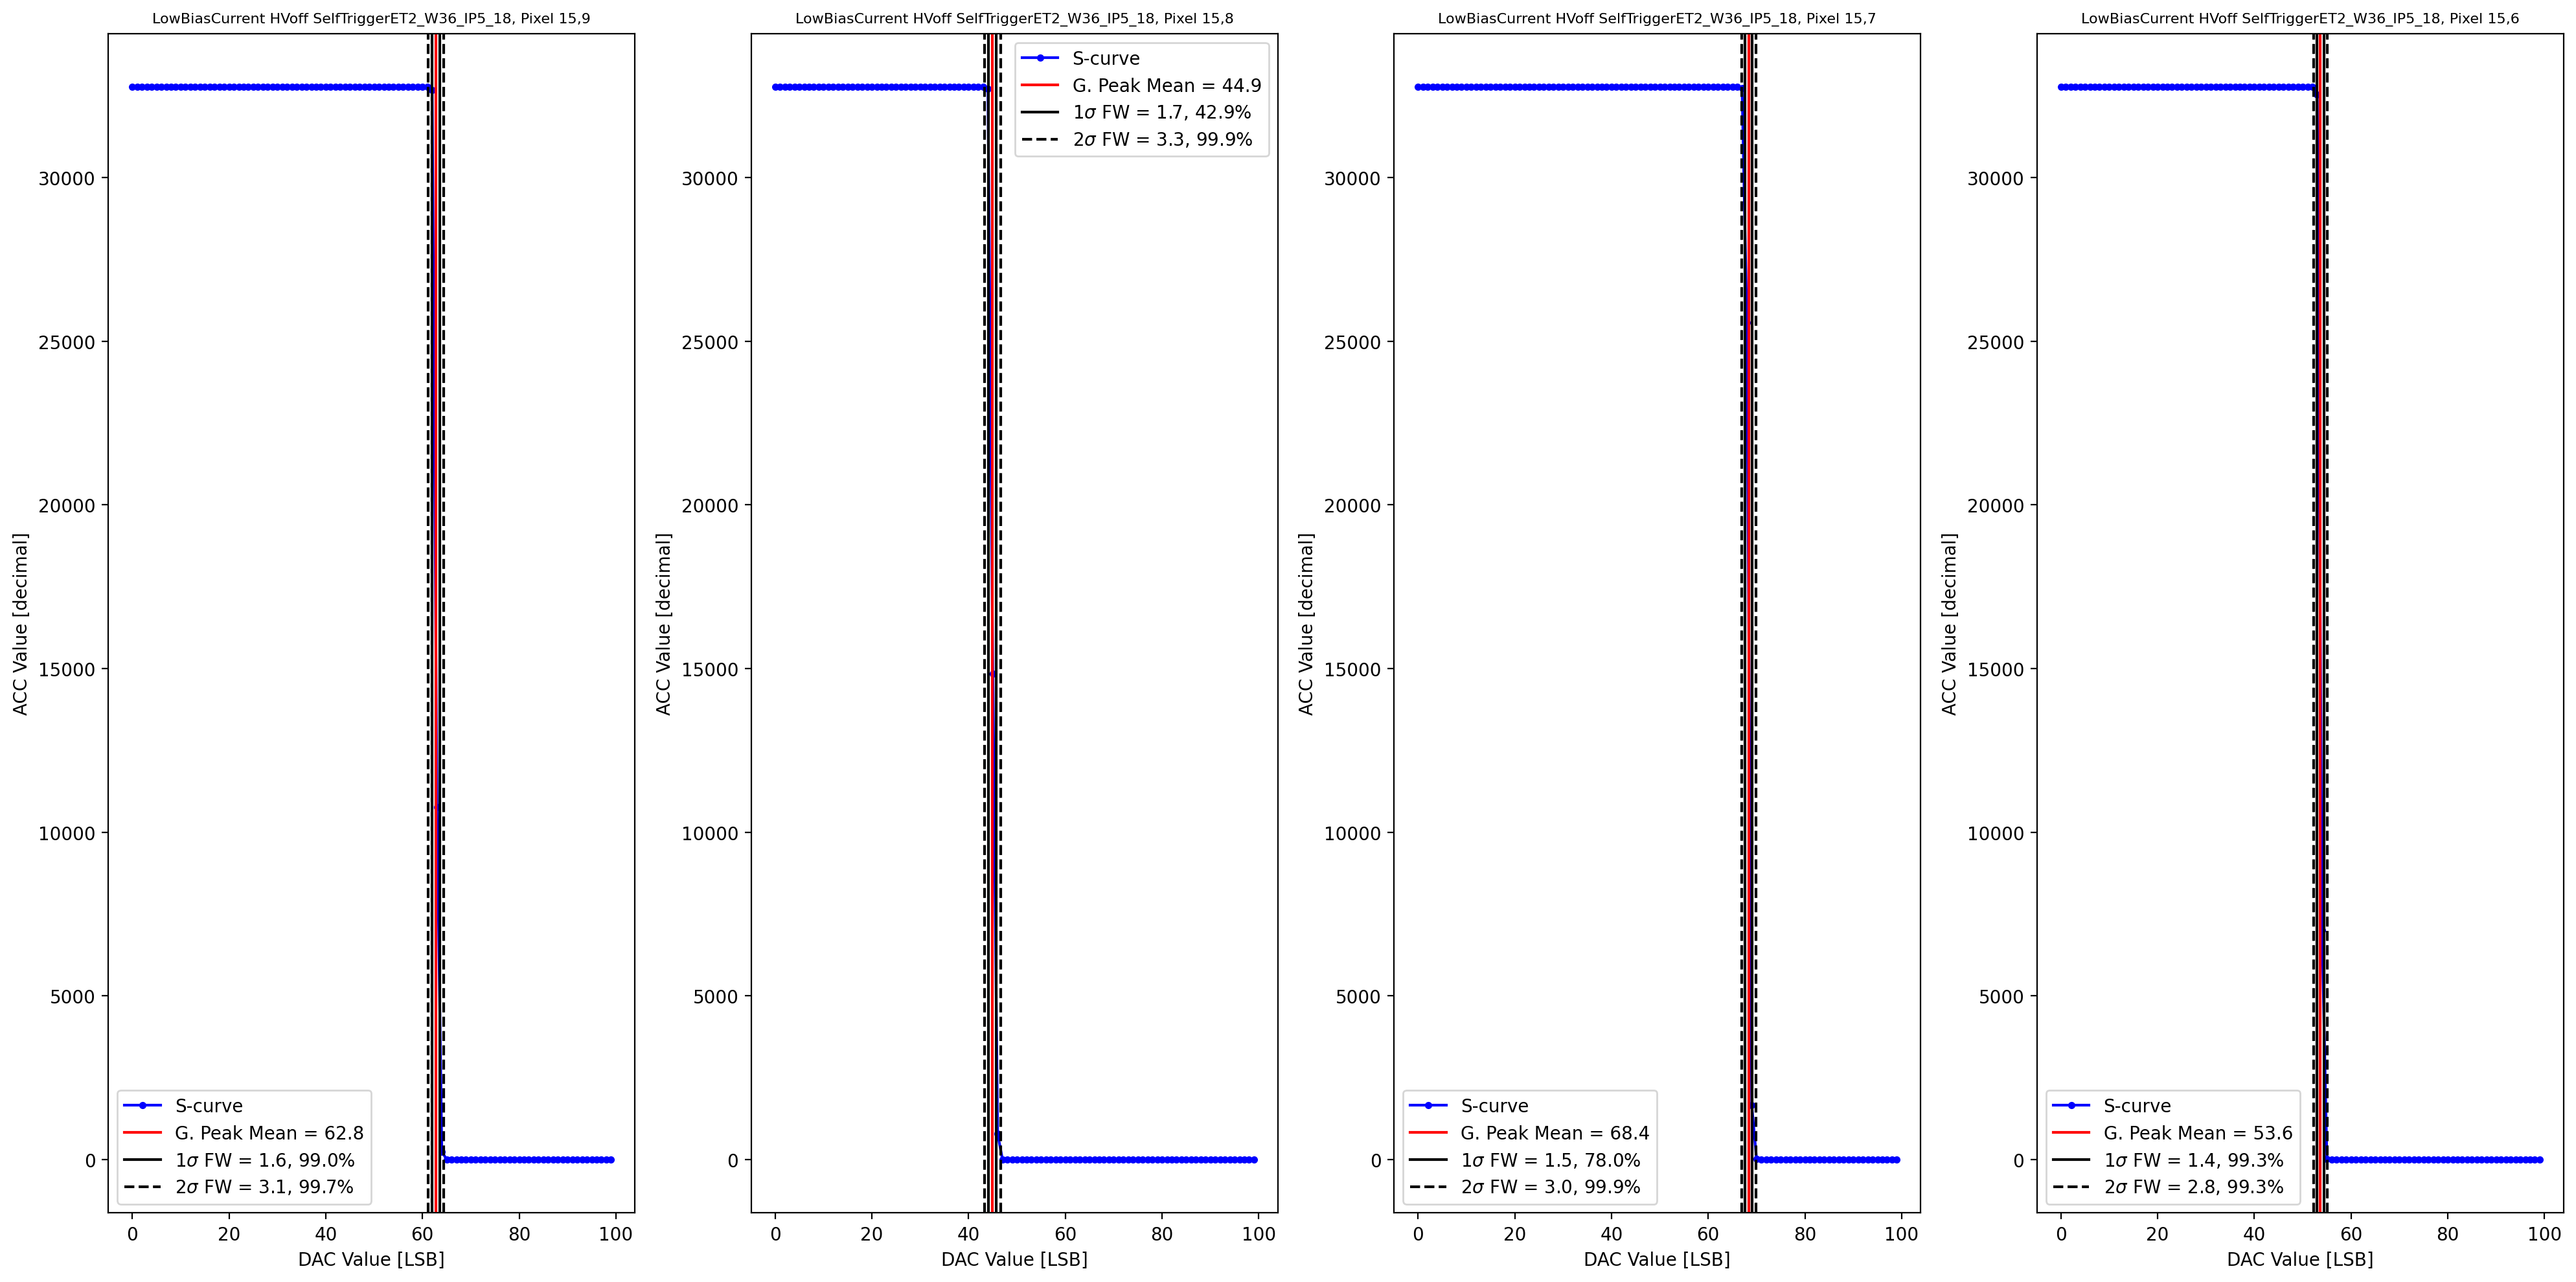

In [37]:
from math import ceil

fig = plt.figure(dpi=200, figsize=(20,10))
u_cl = np.sort(np.unique(col_list))
u_rl = np.sort(np.unique(row_list))
gs = fig.add_gridspec(len(u_rl),len(u_cl))
for ri,row in enumerate(u_rl):
    for ci,col in enumerate(u_cl):
        y = ACC_map_Scurve[row][col]
        maxcdf = np.amax(y)
        onesigmacdf = y[return_closest_xvalue(x, ceil(GMean_map_THCal[row][col] - GSigma_map_THCal[row][col]))] - y[return_closest_xvalue(x, ceil(GMean_map_THCal[row][col] + GSigma_map_THCal[row][col]))]
        twosigmacdf = y[return_closest_xvalue(x, ceil(GMean_map_THCal[row][col] - 2*GSigma_map_THCal[row][col]))] - y[return_closest_xvalue(x, ceil(GMean_map_THCal[row][col] + 2*GSigma_map_THCal[row][col]))]

        ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
        ax0.plot(DAC_range, ACC_map_Scurve[row][col], 'b.-', label="S-curve")
        ax0.axvline(GMean_map_THCal[row][col], color='r', label=f"G. Peak Mean = {GMean_map_THCal[row][col]:.1f}")
        ax0.axvline(GMean_map_THCal[row][col]+GSigma_map_THCal[row][col], color='k', label=fr"1$\sigma$ FW = {2*GSigma_map_THCal[row][col]:.1f}, {100*onesigmacdf/maxcdf:.1f}%")
        ax0.axvline(GMean_map_THCal[row][col]-GSigma_map_THCal[row][col], color='k')
        ax0.axvline(GMean_map_THCal[row][col]+2*GSigma_map_THCal[row][col], color='k', ls="--", label=fr"2$\sigma$ FW = {4*GSigma_map_THCal[row][col]:.1f}, {100*twosigmacdf/maxcdf:.1f}%")
        ax0.axvline(GMean_map_THCal[row][col]-2*GSigma_map_THCal[row][col], color='k', ls="--")
        ax0.set_xlabel("DAC Value [LSB]")
        ax0.set_ylabel("ACC Value [decimal]")
        plt.legend()
        plt.title(chip_figtitle+f", Pixel {row},{col}", size=8)
plt.tight_layout()
plt.savefig(fig_path+"/ACC_Gaussian_SCurve_"+chip_figname+"_"+datetime.date.today().isoformat()+".png")

In [ ]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")

row = 14
col = 7
column_indexer_handle.set(col)
row_indexer_handle.set(row)

pixel_decoded_register_write("Bypass_THCal", "1")
pixel_decoded_register_write("QInjEn", "1")
pixel_decoded_register_write("QSel", format(0x0e, '05b'))
g_mean  = round(GMean_map_THCal[row][col])
g_sigma = ceil(GSigma_map_THCal[row][col])
DAC = int(g_mean+(1*g_sigma))
pixel_decoded_register_write("disDataReadout", "0")
pixel_decoded_register_write("disTrigPath", "0")
pixel_decoded_register_write("DAC", format(DAC, '010b'))

In [ ]:
new_columns = {
    'note': f'{chip_figname}',
}

for col in new_columns:
    acc_df[col] = new_columns[col]

outdir = Path('../ETROC-Data')
outfile = outdir / 'ACCScurveHistory.sqlite'

init_cmd = [
    'cd ' + str(outdir.resolve()),
    'git stash -u',
    'git pull',
]
end_cmd = [
    'cd ' + str(outdir.resolve()),
    'git add ACCScurveHistory.sqlite',
    'git commit -m "Added new history entry"',
    'git push',
    'git stash pop',
    'git stash clear',
]
init_cmd = [x + '\n' for x in init_cmd]
end_cmd  = [x + '\n' for x in end_cmd]

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

for cmd in init_cmd:
    p.stdin.write(cmd + "\n")
p.stdin.close()
p.wait()

print(p.stdout.read())

with sqlite3.connect(outfile) as sqlconn:
    acc_df.to_sql('acc_scurve', sqlconn, if_exists='append', index=False)

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

for cmd in end_cmd:
    p.stdin.write(cmd + "\n")
p.stdin.close()
p.wait()

p.stdin.close()

print(p.stdout.read())


# Qinj S Curve Scan + ACC scan

In [51]:
#print(BL_map_THCal[row][col]-3*NW_map_THCal[row][col])

# min_threshold = int(BL_map_THCal[row][col]-3*NW_map_THCal[row][col])
min_threshold = 40
scan_step = 4

### Nominal chip
# thresholds = {
#     5: np.arange(min_threshold,  min_threshold + 60,  scan_step),
#     6: np.arange(min_threshold,  min_threshold + 60,  scan_step),
#     8: np.arange(min_threshold,  min_threshold + 90,  scan_step),
#     10: np.arange(min_threshold, min_threshold + 100, scan_step),
#     12: np.arange(min_threshold, min_threshold + 120, scan_step),
#     15: np.arange(min_threshold, min_threshold + 130, scan_step),
#     17: np.arange(min_threshold, min_threshold + 160, scan_step),
#     20: np.arange(min_threshold, min_threshold + 180, scan_step),
#     22: np.arange(min_threshold, min_threshold + 200, scan_step),
#     25: np.arange(min_threshold, min_threshold + 220, scan_step),
#     27: np.arange(min_threshold, min_threshold + 240, scan_step),
#     30: np.arange(min_threshold, min_threshold + 260, scan_step),
# }

### FFF corner wafer
thresholds = {
    5: np.arange(min_threshold,  min_threshold + 50,  scan_step),
    6: np.arange(min_threshold,  min_threshold + 60,  scan_step),
    8: np.arange(min_threshold,  min_threshold + 60,  scan_step),
    10: np.arange(min_threshold, min_threshold + 70, scan_step),
    12: np.arange(min_threshold, min_threshold + 70, scan_step),
    # 15: np.arange(min_threshold, min_threshold + 80, scan_step),
    15: np.arange(min_threshold, min_threshold + 80, scan_step),
    # 15: np.arange(min_threshold, min_threshold + 51, 25),
    17: np.arange(min_threshold, min_threshold + 90, scan_step),
    20: np.arange(min_threshold, min_threshold + 120, scan_step),
    22: np.arange(min_threshold, min_threshold + 100, scan_step),
    25: np.arange(min_threshold, min_threshold + 110, scan_step),
    27: np.arange(min_threshold, min_threshold + 120, scan_step),
    30: np.arange(min_threshold, min_threshold + 130, scan_step),
}


# thresholds = np.arange(233,450,2)
# thresholds = np.arange(451,500,2)
# thresholds = [10, 150, 240, 250, 260, 270, 280, 290, 300]
# QInjEns = [5, 6, 8, 10, 12, 15, 17, 20, 22, 25, 27, 30]
# QInjEns = [5, 6, 10, 15, 20, 25]
QInjEns = [20]
ACC_map_full_Scurve = {row:{col:{q:{thr:0 for thr in thresholds[q]} for q in QInjEns} for col in range(16)} for row in range(16)}

In [47]:
# old_ACC_map_full_Scurve = ACC_map_full_Scurve

# QInjEns = [5, 6, 10, 15, 20, 25, 30]
# thresholds = np.arange(int(BL_map_THCal[row][col]-3*NW_map_THCal[row][col]),300,2)

# ACC_map_full_Scurve = {row:{col:{q:{thr:0 for thr in thresholds} for q in QInjEns} for col in range(16)} for row in range(16)}

# for row in range(16):
#     for col in range(16):
#         for q in old_ACC_map_full_Scurve[row][col]:
#             for thresh in old_ACC_map_full_Scurve[row][col][q]:
#                 ACC_map_full_Scurve[row][col][q][thresh] = old_ACC_map_full_Scurve[row][col][q][thresh]

# print(ACC_map_full_Scurve[3][3])
# print(ACC_map_full_Scurve[3][3].keys())

## DAC scan with charge injection

In [48]:
row_list = [15]
col_list = [6]
scan_list = list(zip(col_list, row_list))
print(scan_list)
scan_name = "E2_testing_VRef_SCurve"
total_number_pixels = 1
time_per_pixel = 15
dead_time_per_pixel = 10
total_scan_time = total_number_pixels*(time_per_pixel + dead_time_per_pixel)


row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")

today = datetime.date.today()
todaystr = "../ETROC-Data/" + today.isoformat() + "_Array_Test_Results/"
base_dir = Path(todaystr)
base_dir.mkdir(exist_ok=True)

data = []

# Loop for enable/disable charge injection per pixel (single!!!)
for index, row, col in zip(tqdm(range(len(row_list)), desc=f'Pixel Loop', leave=True), row_list, col_list):  
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    # Enable charge injection
    pixel_decoded_register_write("disDataReadout", "0")
    pixel_decoded_register_write("QInjEn", "1")
    pixel_decoded_register_write("disTrigPath", "0")
    # Bypass Cal Threshold
    pixel_decoded_register_write("Bypass_THCal", "1")
    for QInj in tqdm(QInjEns, desc=f'Charge Loop for Pixel {col},{row}', leave=False):
        # Modifying charge injected
        pixel_decoded_register_write("QSel", format(QInj, '05b'))
        for DAC in tqdm(thresholds[QInj][:], desc=f'DAC Loop for Pixel {col},{row}', leave=False):
            print(QInj, DAC)
            threshold_name = scan_name+f'_Pixel_C{col}_R{row}_QInj_{QInj}_Threshold_{DAC}_HV100V_read'

            # Set the DAC v, Qinj {Qinj}fCalue to the value being scanned
            pixel_decoded_register_write("DAC", format(DAC, '010b'))

            # # Enable THCal clock and buffer, disable bypass
            # pixel_decoded_register_write("CLKEn_THCal", "1")
            # pixel_decoded_register_write("BufEn_THCal", "1")
            # pixel_decoded_register_write("Bypass_THCal", "0")
            # pixel_decoded_register_write("TH_offset", format(0x07, '06b'))
            # # Reset the calibration block (active low)
            # pixel_decoded_register_write("RSTn_THCal", "0")
            # pixel_decoded_register_write("RSTn_THCal", "1")
            # # Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
            # pixel_decoded_register_write("ScanStart_THCal", "1")
            # pixel_decoded_register_write("ScanStart_THCal", "0")
            # # Check the calibration done correctly
            # if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
            # BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
            # NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
            # # Disable clock and buffer before charge injection 
            # pixel_decoded_register_write("CLKEn_THCal", "0") 
            # pixel_decoded_register_write("BufEn_THCal", "0")
            # pixel_decoded_register_write("Bypass_THCal", "1")

            # tmp_dir = Path(todaystr+threshold_name)
            # tmp_dir.mkdir(exist_ok=True)

            # np.save(todaystr+threshold_name+"/BL.npy", np.array([BL_map_THCal[row, col]]))
            # np.save(todaystr+threshold_name+"/NW.npy", np.array([NW_map_THCal[row, col]]))

            # Save BL, NW and relevant information together in pickle
            # template = {
            #     'BL': BL_map_THCal[row, col],
            #     'NW': NW_map_THCal[row, col],
            #     'row': row,
            #     'col': col,
            #     'charge': QInj,
            #     'threshold': DAC,
            #     'time': datetime.datetime.now(),
            # }
            # data += [template]
            # with open(tmp_dir/'info.pkl', 'wb') as file:
            #     pickle.dump(template, file)
            
            parser = run_script.getOptionParser()
            (options, args) = parser.parse_args(args=f"--firmware --useIPC --hostname 192.168.2.7 -t {int(total_scan_time)} -o {threshold_name} -v -w --reset_till_linked -s 0x000C".split())
            # (options, args) = parser.parse_args(args=f"--firmware --useIPC --hostname 192.168.2.7 -t {int(total_scan_time)} -o {threshold_name} -v -w --compressed_translation -s 0x000C".split())
            IPC_queue = multiprocessing.Queue()
            process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_{DAC}'))
            process.start()

            time.sleep(1)
            IPC_queue.put('start L1A trigger bit')
            # IPC_queue.put('start L1A 1MHz clean')
            # IPC_queue.put('start L1A 250kHz')
            while not IPC_queue.empty():
                pass

            delay = '0000110111100101' ## enhance data: 485
            hex_delay = hex(int(delay, base=2))
            IPC_queue.put(f'change delay {hex_delay}') 
            while not IPC_queue.empty():
                pass

            # DAQ time
            time.sleep(time_per_pixel)

            # Stop DAQ fifo
            IPC_queue.put('stop DAQ')

            # Stop Qinj and L1A, join process
            IPC_queue.put('stop L1A trigger bit')

            # IPC_queue.put('stop L1A 250kHz')
            while not IPC_queue.empty():
                pass
            # allow threads to exit
            IPC_queue.put('allow threads to exit')
            process.join()

            # # Enable THCal clock and buffer and bypass
            # pixel_decoded_register_write("CLKEn_THCal", "1")
            # pixel_decoded_register_write("BufEn_THCal", "1")

            # # Reset the calibration block (active low)
            # pixel_decoded_register_write("RSTn_THCal", "0")
            # pixel_decoded_register_write("RSTn_THCal", "1")

            # # Start and Stop the calibration, maybe pause for 1ms (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
            # pixel_decoded_register_write("ScanStart_THCal", "1")
            # pixel_decoded_register_write("ScanStart_THCal", "0")
            # # Fetch the status registers
            # if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
            # ACC_map_full_Scurve[row][col][QInj][DAC] = pixel_decoded_register_read("ACC", "Status", need_int=True)
            # # Disable THCal clock and buffer and bypass
            # pixel_decoded_register_write("CLKEn_THCal", "0")
            # pixel_decoded_register_write("BufEn_THCal", "0")

            # time.sleep(1)

            ### Make sure clear fifo
            # (options, args) = parser.parse_args(args=f"--firmware --useIPC --hostname 192.168.2.3 --nodaq".split())
            # process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, 'main_process'))
            # process.start()
            # time.sleep(1)
            # process.join()
            # time.sleep(1)
            
    # Set the DAC value to the vpreviously found BL + Offset (7)
    # pixel_decoded_register_write("DAC", format(int(BL_map_THCal[row,col]+7), '010b'))
    g_mean  = round(GMean_map_THCal[row][col])
    g_sigma = ceil(GSigma_map_THCal[row][col])
    DAC = int(g_mean+(2*g_sigma))
    # Disable charge injection
    pixel_decoded_register_write("QInjEn", "0")
    pixel_decoded_register_write("disDataReadout", "1")
    pixel_decoded_register_write("disTrigPath", "1")

sCurve_df = pandas.DataFrame(data=data)

outdir = Path('../ETROC-Data')
outdir = outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
outdir.mkdir(exist_ok=True)
outfile = outdir / (scan_name + "_at_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv")
sCurve_df.to_csv(outfile, index=False)

[(6, 15)]


Pixel Loop:   0%|          | 0/1 [00:00<?, ?it/s]


20 140


20 144


20 148


20 152


20 156


20 160


20 164


20 168


20 172


20 176


20 180


20 184


20 188


20 192


20 196


20 200


20 204


20 208


20 212


20 216


20 220


20 224


20 228


20 232


20 236




Pixel Loop: 100%|██████████| 1/1 [12:44<00:00, 764.42s/it]


In [ ]:
# Stop Qinj and L1A, join process
IPC_queue.put('stop L1A trigger bit')

In [ ]:
# Stop DAQ fifo
IPC_queue.put('stop DAQ')
# allow threads to exit
IPC_queue.put('allow threads to exit')
process.join()

## ACC Plots

In [ ]:
fig = plt.figure(dpi=50, figsize=(16,16))
gs = fig.add_gridspec(len(scan_list),len(scan_list))
u_cl = np.sort(np.unique(col_list))
u_rl = np.sort(np.unique(row_list))
for ri,row in enumerate(u_rl):
    for ci,col in enumerate(u_cl):
        ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
        ax0.axvline(BL_map_THCal[row][col], color='r', label="THCal BL")
        ax0.axvline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='k', label="THCal NW")
        ax0.axvline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='k')
        for QInj in QInjEns:
            ax0.plot(thresholds, ACC_map_full_Scurve[row][col][QInj].values(), '.-', label=f"{QInj} fC")
        ax0.set_xlabel("DAC Value [decimal]")
        ax0.set_ylabel("ACC Value [decimal]")
        ax0.text(0.7, 0.8, f"Pixel {row},{col}", transform=ax0.transAxes)
        plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## Counts

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from fnmatch import fnmatch

In [52]:
root = '../ETROC-Data'
file_pattern = "*translated*.dat"
hitmap_full_Scurve = {row:{col:{q:{thr:0 for thr in thresholds[q]} for q in QInjEns} for col in range(16)} for row in range(16)}
for index, row, col in zip((range(len(row_list))), row_list, col_list):
    for QInj in (QInjEns):
        for DAC in (thresholds[QInj]):
            print(f'Pixel {col},{row} - {QInj} fC - DAC {DAC}')
            path_pattern = f"*{today.isoformat()}_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C{col}_R{row}_QInj_{QInj}_Threshold_{DAC}_HV100V_read"
            file_list = []
            for path, subdirs, files in os.walk(root):
                if not fnmatch(path, path_pattern): continue
                for name in files:
                    pass
                    if fnmatch(name, file_pattern):
                        file_list.append(os.path.join(path, name))
                        print(file_list[-1])
            current_bcid = -1
            previous_bcid = -1
            total_files = len(file_list)
            for file_index, file_name in enumerate(file_list):
                print(f"{file_index+1}/{total_files}")
                with open(file_name) as infile:
                    for line in infile:
                        text_list = line.split()
                        if(text_list[2]=="HEADER"): current_bcid = int(text_list[8])
                        elif(text_list[2]=="TRAILER"): previous_bcid = current_bcid
                        # if(previous_bcid==-1 or (current_bcid-previous_bcid<=68 if current_bcid>=previous_bcid else current_bcid+3564-previous_bcid<=68)): continue
                        # if(previous_bcid==-1 or (current_bcid-previous_bcid<=2 if current_bcid>=previous_bcid else current_bcid+3564-previous_bcid<=2)): continue
                        if text_list[2]!="DATA": continue
                        c_running = int(text_list[6])
                        r_running = int(text_list[8])
                        hitmap_full_Scurve[r_running][c_running][QInj][DAC] += 1 

Pixel 6,15 - 20 fC - DAC 40
../ETROC-Data/2023-07-18_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C6_R15_QInj_20_Threshold_40_HV100V_read/TDC_Data_translated_0.dat
../ETROC-Data/2023-07-18_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C6_R15_QInj_20_Threshold_40_HV100V_read/TDC_Data_translated_1.dat
../ETROC-Data/2023-07-18_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C6_R15_QInj_20_Threshold_40_HV100V_read/TDC_Data_translated_2.dat
1/3
2/3
3/3
Pixel 6,15 - 20 fC - DAC 44
../ETROC-Data/2023-07-18_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C6_R15_QInj_20_Threshold_44_HV100V_read/TDC_Data_translated_0.dat
../ETROC-Data/2023-07-18_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C6_R15_QInj_20_Threshold_44_HV100V_read/TDC_Data_translated_1.dat
../ETROC-Data/2023-07-18_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C6_R15_QInj_20_Threshold_44_HV100V_read/TDC_Data_translated_2.dat
../ETROC-Data/2023-07-18_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C6_R15_QInj_20_Threshold_

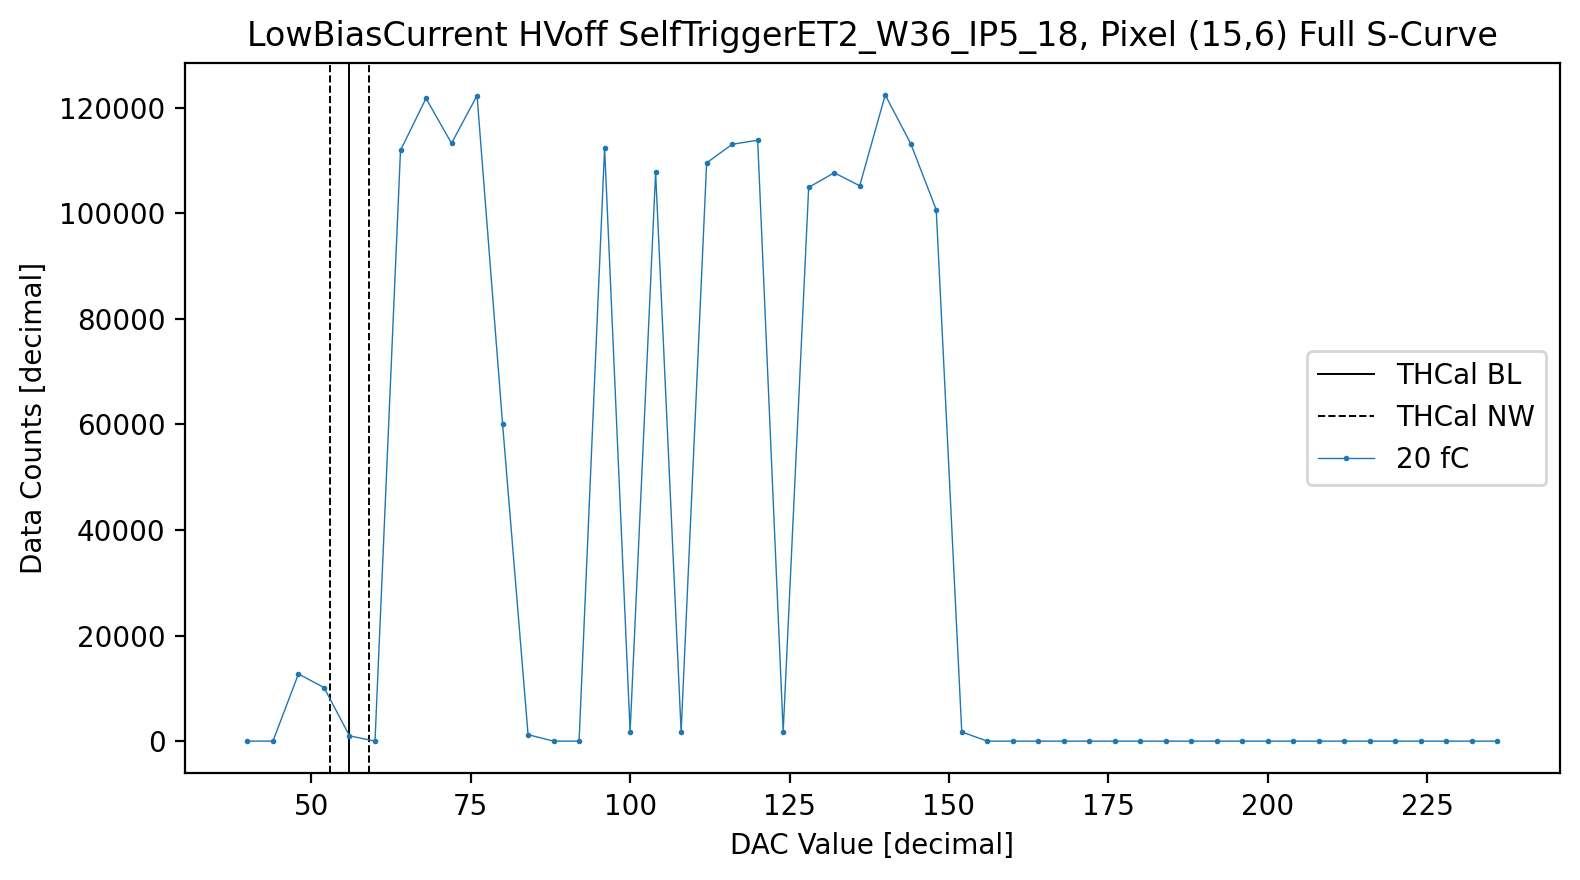

In [53]:
fig = plt.figure(dpi=200, figsize=(8,4.5))
gs = fig.add_gridspec(len(scan_list),len(scan_list))
u_cl = np.sort(np.unique(col_list))
u_rl = np.sort(np.unique(row_list))
for ri,row in enumerate(u_rl):
    for ci,col in enumerate(u_cl):
        ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
        ax0.axvline(BL_map_THCal[row][col], color='k', label="THCal BL", lw=0.7)
        ax0.axvline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='k', ls='--', label="THCal NW", lw=0.7)
        ax0.axvline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='k', ls='--', lw=0.7)
        # ax0.axvline(GMean_map_THCal[row][col], color='k', label="THCal BL", lw=0.7)
        # ax0.axvline(GMean_map_THCal[row][col]+2*GSigma_map_THCal[row][col], color='k', ls='--', label="THCal NW", lw=0.7)
        # ax0.axvline(GMean_map_THCal[row][col]-2*GSigma_map_THCal[row][col], color='k', ls='--', lw=0.7)
        for QInj in QInjEns[0:]:
            ax0.plot(thresholds[QInj], hitmap_full_Scurve[row][col][QInj].values(), '.-', label=f"{QInj} fC",lw=0.5,markersize=2)
        ax0.set_xlabel("DAC Value [decimal]")
        ax0.set_ylabel("Data Counts [decimal]")
        # ax0.text(0.7, 0.8, f"Pixel {row},{col}", transform=ax0.transAxes)
        plt.legend(loc="center right")
plt.title(f"{chip_figtitle}, Pixel ({row},{col}) Full S-Curve")
plt.tight_layout()
plt.savefig(fig_path+"/Full_S-Curve_"+chip_figname+"_"+datetime.date.today().isoformat()+".png")

In [ ]:
def find_largest_non_zero_idx(array, key_array):
    array = np.array(list(array))
    np_key = np.where(array!=0, key_array, 0)
    return key_array[np.argmax(np_key)]

In [ ]:
fig = plt.figure(dpi=200, figsize=(8,4.5))
gs = fig.add_gridspec(len(scan_list),len(scan_list))
u_cl = np.sort(np.unique(col_list))
u_rl = np.sort(np.unique(row_list))
for ri,row in enumerate(u_rl):
    for ci,col in enumerate(u_cl):
        ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
        ax0.axhline(BL_map_THCal[row][col], color='k', label="THCal BL", lw=0.7)
        ax0.axhline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='k', ls='--', label="THCal NW", lw=0.7)
        ax0.axhline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='k', ls='--', lw=0.7)
        X = []
        Y = []
        for QInj in QInjEns[0:]:
            tp_thr = find_largest_non_zero_idx(hitmap_full_Scurve[row][col][QInj].values(), thresholds[QInj])
            X.append(QInj)
            Y.append(tp_thr)
        ax0.plot(X, Y,'ro')
        m, b = np.polyfit(X, Y, 1)
        topEdge = BL_map_THCal[row][col]+NW_map_THCal[row][col]
        min_charge = (topEdge - b)/m
        ax0.plot(np.linspace(min_charge,30,100), b + m*np.linspace(min_charge,30,100), 'b-', label=f'DAC = {m:.3f}Q + {b:.3f}')
        ax0.set_xlabel("Charge Injected (Allegedly) [fC]")
        ax0.set_ylabel("DAC Threshold [decimal]")
        plt.legend(loc="center right")
plt.title(f"{chip_name}, Pixel ({row},{col}) Full S-Curve, PA Low Bias Current Mode")
plt.tight_layout()
plt.show()

In [ ]:
print(Y)

In [ ]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
# Loop for threshold calibration
for row in [3]:
    for col in [3]:
# for index,row,col in zip(tqdm(range(16)), row_list, col_list):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # Maybe required to make this work
        # pixel_decoded_register_write("enable_TDC", "0")
        # pixel_decoded_register_write("testMode_TDC", "0")
        # Enable THCal clock and buffer, disable bypass
        pixel_decoded_register_write("CLKEn_THCal", "1")
        pixel_decoded_register_write("BufEn_THCal", "1")
        pixel_decoded_register_write("Bypass_THCal", "0")
        pixel_decoded_register_write("TH_offset", format(0x07, '06b'))
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Check the calibration done correctly
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
        NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
        # Disable clock and buffer before charge injection 
        pixel_decoded_register_write("CLKEn_THCal", "0") 
        pixel_decoded_register_write("BufEn_THCal", "0")
        # Set Charge Inj Q to 15 fC
        pixel_decoded_register_write("QSel", format(0x0e, '05b'))

# Disconnect chip

In [ ]:
conn.disconnect()